## Created on Thr Aug 15 2024

## @author: Jeong-Woon, Park

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

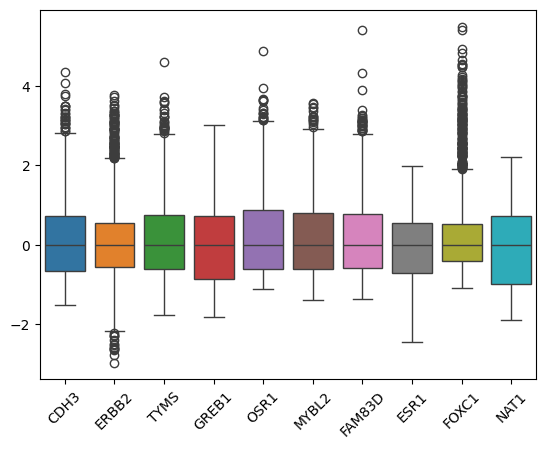

In [2]:
# Load X_train gene expression dataset.
X_train = pd.read_csv("X_train_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Train)
plt.rcdefaults()
sns.boxplot(X_train)
plt.xticks(rotation = 45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'CDH3'),
  Text(1, 0, 'ERBB2'),
  Text(2, 0, 'TYMS'),
  Text(3, 0, 'GREB1'),
  Text(4, 0, 'OSR1'),
  Text(5, 0, 'MYBL2'),
  Text(6, 0, 'FAM83D'),
  Text(7, 0, 'ESR1'),
  Text(8, 0, 'FOXC1'),
  Text(9, 0, 'NAT1')])

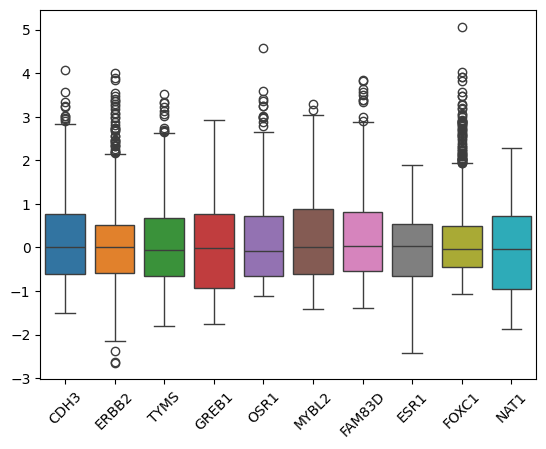

In [3]:
# Load X_test gene expression dataset.
X_test = pd.read_csv("X_test_feature_select.csv", sep = "\t", index_col = "Unnamed: 0")

# Feature distritubion after normalization (Test)
plt.rcdefaults()
sns.boxplot(X_test)
plt.xticks(rotation = 45)

In [4]:
# Load PAM50 subtype dataset.
target = pd.read_csv("GPL11154_PAM50.csv", sep = "\t", index_col = "geo_accession")
target.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528079,Basal
GSM2528080,LumA
GSM2528081,LumB
GSM2528082,LumA
GSM2528084,Basal


In [5]:
# Load test PAM50 subtype dataset.
y_train = target.loc[X_train.index.tolist(), :]
y_train.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2528830,Her2
GSM2530511,LumA
GSM2529478,LumA
GSM2528452,LumA
GSM2531266,LumB


In [6]:
# Load test PAM50 subtype dataset.
y_test = target.loc[X_test.index.tolist(), :]
y_test.head()

,BRCA_Subtype_PAM50
geo_accession,
GSM2530931,LumB
GSM2528314,Basal
GSM2528222,Basal
GSM2531033,LumA
GSM2529552,LumB


In [7]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoder = encoder.transform(y_train)
y_test_encoder = encoder.transform(y_test)

# Create series.
y_train = pd.Series(y_train_encoder, index = y_train.index)
y_test = pd.Series(y_test_encoder, index = y_test.index)

In [8]:
# Downsampling based on k-means cluster,
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state = 42)
X_res, y_res = cc.fit_resample(X_train, y_train)

Text(0, 0.5, 'Frequency')

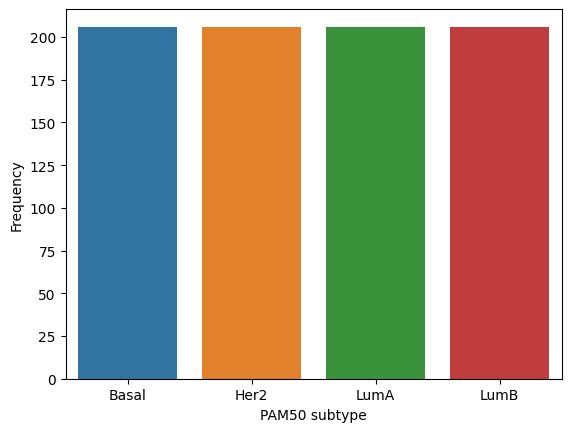

In [9]:
# Check count for each class in the training data.
class_counts = y_res.groupby(y_res).size()
class_counts.index = ["Basal", "Her2", "LumA", "LumB"]
sns.barplot(x = class_counts.index, y = class_counts.values, hue = class_counts.index)
plt.xlabel("PAM50 subtype")
plt.ylabel("Frequency")

### Compare model performance between original and undersampled data.

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score, make_scorer, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_validate
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve
from imblearn.metrics import specificity_score, sensitivity_score

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 123)
clf = SVC(random_state = 42, probability = True, kernel = "linear")

origianl_score = cross_validate(clf, X_train, y_train, cv = cv, scoring = "accuracy", return_train_score = True)
undersample_score = cross_validate(clf, X_res, y_res, cv = cv, scoring = "accuracy", return_train_score = True)

print("Mean train accuracy (original) =", np.mean(origianl_score["train_score"]), "±", np.std(origianl_score["train_score"]))
print("Mean validation accuracy (original) =", np.mean(origianl_score["test_score"]), "±", np.std(origianl_score["test_score"]), "\n")
print("Mean train accuracy (undersampled) =", np.mean(undersample_score["train_score"]), "±", np.std(undersample_score["train_score"]))
print("Mean validation accuracy (undersampled) =", np.mean(undersample_score["test_score"]), "±", np.std(undersample_score["test_score"]))

Mean train accuracy (original) = 0.9114435024632644 ± 0.002464115440459739
Mean validation accuracy (original) = 0.904436995886972 ± 0.01972343728913522 

Mean train accuracy (undersampled) = 0.8954966516436228 ± 0.005836939745741601
Mean validation accuracy (undersampled) = 0.8722083455774314 ± 0.037360414931413864


### Hyperparameter tuning using GridSearchCV

In [11]:
# Perfome grid search with 10-fold stratified cross-validation.
hyperparameters = {'C' : [0.001, 0.01, 0.1, 1],
                   'class_weight' : [None, 'balanced']}
specificity = make_scorer(specificity_score, average = "macro")
sensitivity = make_scorer(sensitivity_score, average = "macro")

scoring = {"accuracy" : "accuracy",
           "specificity" : specificity,
           "sensitivity" : sensitivity,
           "f1-score" : "f1_macro",
           "auc" : "roc_auc_ovr"}

optimizer = GridSearchCV(clf, hyperparameters, cv = cv, scoring = scoring, 
                         n_jobs = -1, return_train_score = True, refit = "accuracy")
best_model = optimizer.fit(X_train, y_train)

In [12]:
print('가장 좋은 C 값:', best_model.best_estimator_.get_params()['C'])
print('가장 좋은 class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print("가장 좋은 Score :", best_model.best_score_)

가장 좋은 C 값: 1
가장 좋은 class_weight: None
가장 좋은 Score : 0.904436995886972


In [13]:
# Make GridSearCV result.
CV_result = pd.DataFrame(best_model.cv_results_)
select_columns = ['params',
                  'mean_train_accuracy', 'std_train_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
                  'mean_train_specificity', 'std_train_specificity', 'mean_test_specificity', 'std_test_specificity',
                  'mean_train_sensitivity', 'std_train_sensitivity', 'mean_test_sensitivity', 'std_test_sensitivity',
                  'mean_train_f1-score', 'std_train_f1-score', 'mean_test_f1-score', 'std_test_f1-score',
                  'mean_train_auc', 'std_train_auc', 'mean_test_auc', 'std_test_auc']

Final_GRID_result = CV_result.loc[:, select_columns].sort_values(by = 'mean_test_accuracy', ascending = False).reset_index(drop = True).transpose()
Final_GRID_result

,0,1,2,3,4,5,6,7
params,"{'C': 1, 'class_weight': None}","{'C': 0.1, 'class_weight': None}","{'C': 0.1, 'class_weight': 'balanced'}","{'C': 1, 'class_weight': 'balanced'}","{'C': 0.01, 'class_weight': None}","{'C': 0.01, 'class_weight': 'balanced'}","{'C': 0.001, 'class_weight': 'balanced'}","{'C': 0.001, 'class_weight': None}"
mean_train_accuracy,0.911444,0.90808,0.895444,0.900556,0.890178,0.883583,0.8632,0.779256
std_train_accuracy,0.002464,0.002536,0.00405,0.003828,0.002962,0.00347,0.002977,0.003359
mean_test_accuracy,0.904437,0.901653,0.8901,0.888861,0.887215,0.8802,0.861068,0.777931
std_test_accuracy,0.019723,0.018632,0.020058,0.021072,0.020541,0.021423,0.020406,0.021651
mean_train_specificity,0.962876,0.961303,0.962446,0.96406,0.95126,0.958508,0.950559,0.884505
std_train_specificity,0.001044,0.001115,0.001428,0.001429,0.001458,0.001169,0.001369,0.001874
mean_test_specificity,0.96032,0.958724,0.960419,0.959964,0.949821,0.957233,0.949675,0.884009
std_test_specificity,0.008689,0.008477,0.007709,0.008094,0.009612,0.008011,0.008103,0.010952
mean_train_sensitivity,0.897708,0.888947,0.908268,0.914017,0.854903,0.895075,0.864613,0.684244


### Model evaluation using hyperparameter

In [14]:
# Model fitting and prediction.
model = best_model.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [15]:
# Classification report
print(classification_report(y_test, y_pred, target_names = ["Basal", "Her2", "LumA", "LumB"]))

              precision    recall  f1-score   support

       Basal       0.95      0.89      0.92        92
        Her2       0.88      0.88      0.88        89
        LumA       0.92      0.92      0.92       450
        LumB       0.80      0.81      0.80       200

    accuracy                           0.89       831
   macro avg       0.89      0.87      0.88       831
weighted avg       0.89      0.89      0.89       831



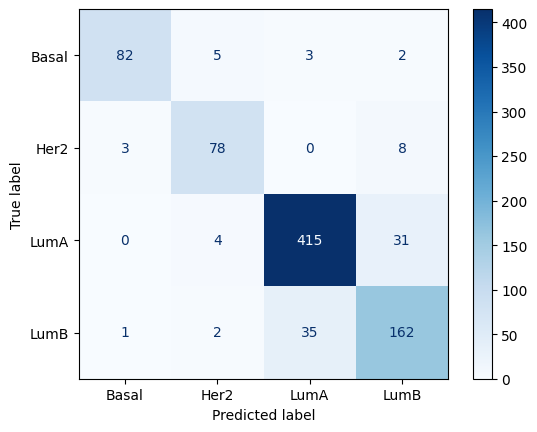

In [16]:
# Confusion matrix
plt.rcdefaults()
display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                display_labels = ["Basal", "Her2", "LumA", "LumB"],
                                                cmap = plt.cm.Blues, normalize = None)
plt.grid(False)
plt.show()

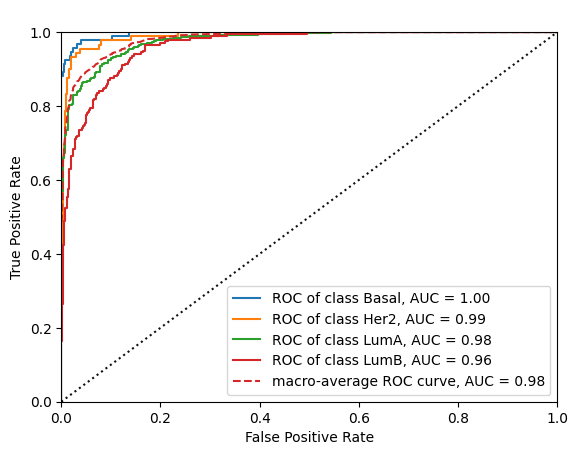

<Axes: title={'center': ' '}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [17]:
# ROC curve
plt.rcdefaults()
visualizer = ROCAUC(model, classes = ["Basal", "Her2", "LumA", "LumB"], 
                    macro = True, micro = False, title = " ")

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)
visualizer.show()

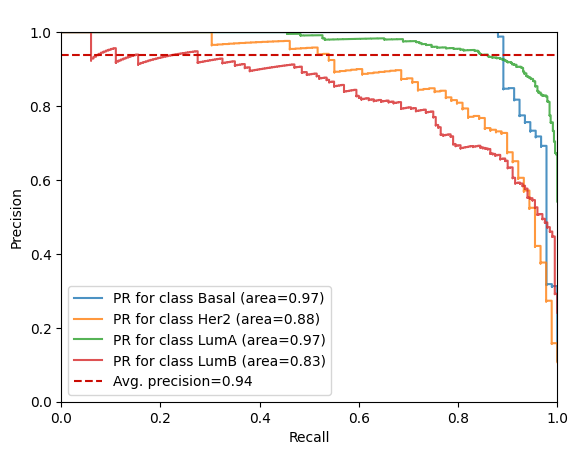

<Axes: title={'center': ' '}, xlabel='Recall', ylabel='Precision'>

In [18]:
# Precision-Recall curve
plt.rcdefaults()
visualizer = PrecisionRecallCurve(model, per_class = True, classes = ["Basal", "Her2", "LumA", "LumB"], title = " ")
visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)       
visualizer.show()

In [19]:
# Accuracy
accuracy_score(y_test, y_pred)

0.8868832731648616

In [20]:
# Macro average specificity
specificity_score(y_test, y_pred, average = "macro")

0.9537621803117495

In [21]:
# Macro average sensitivity
sensitivity_score(y_test, y_pred, average = "macro")

0.874982766107583

In [22]:
# Macro F1 score
f1_score(y_test, y_pred, average = "macro")

0.880220348333163

In [23]:
# Macro average AUROC
roc_auc_score(y_test, y_pred_proba, multi_class = "ovr", average = "macro")

0.9813482182798827